In [8]:
import tensorflow as tf
import numpy as np

# Path model TFLite
TFLITE_MODEL_PATH = r"C:\Users\adity\student_kd_fp16.tflite"  # ganti sesuai model Anda

# Load interpreter
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

# Ambil detail input & output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape :", input_details[0]["shape"])
print("Input dtype :", input_details[0]["dtype"])
print("Output dtype:", output_details[0]["dtype"])


Input shape : [  1 224 224   3]
Input dtype : <class 'numpy.float32'>
Output dtype: <class 'numpy.float32'>


In [9]:
import cv2
import os

IMG_SIZE = 224

def preprocess_image(img_path, input_dtype):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0

    img = np.expand_dims(img, axis=0)

    # Jika model INT8
    if input_dtype == np.int8:
        scale, zero_point = input_details[0]["quantization"]
        img = img / scale + zero_point
        img = img.astype(np.int8)

    return img


In [10]:
img_path = r"C:\Users\adity\Downloads\Tomato Leaf Disease Dataset\TomatoDataset\Tomato___Tomato_Yellow_Leaf_Curl_Virus\IMG20240812111244.jpg"

input_data = preprocess_image(img_path, input_details[0]["dtype"])

interpreter.set_tensor(input_details[0]["index"], input_data)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]["index"])
pred_class = np.argmax(output)

print("Predicted class index:", pred_class)


Predicted class index: 2


In [11]:
from sklearn.metrics import accuracy_score

DATASET_DIR = r"C:\Users\adity\Downloads\Tomato Leaf Disease Dataset\TomatoDataset"
class_names = sorted(os.listdir(DATASET_DIR))

y_true = []
y_pred = []

for label_idx, class_name in enumerate(class_names):
    class_path = os.path.join(DATASET_DIR, class_name)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        input_data = preprocess_image(
            img_path,
            input_details[0]["dtype"]
        )

        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]["index"])
        pred = np.argmax(output)

        y_true.append(label_idx)
        y_pred.append(pred)


In [12]:
acc = accuracy_score(y_true, y_pred)
print(f"Akurasi External Dataset: {acc:.4f}")


Akurasi External Dataset: 0.0696


In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)


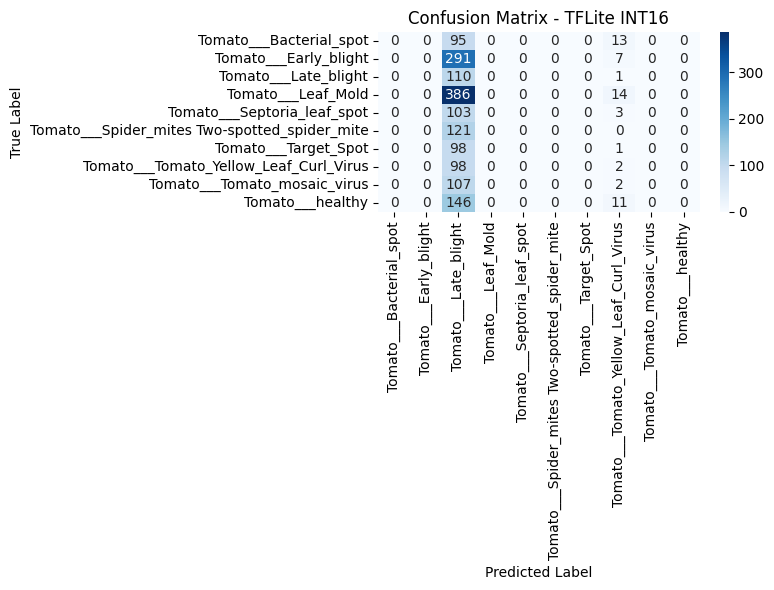

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TFLite INT16")
plt.tight_layout()
plt.show()
